In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import imageio

import torch
import torchvision
import torchvision.transforms as transforms
import scipy.ndimage as ndi
from IPython.display import clear_output


In [9]:
torch.cuda.is_available()

True

Load the data set


In [10]:
import os
filepath='C:/Users/Bruger/Desktop/courses/deep learning 2020/9-project'
os.chdir(filepath)

trainset=torch.load('cifar_train')
testset=torch.load('cifar_test')


#Choose the batch_size

batchs=4


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchs,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchs,
                                         shuffle=True)

print('loaders loaded')

loaders loaded


In [11]:
trainset[0][1].shape

torch.Size([3, 32, 32])

In [12]:
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)

Show some images of the training data


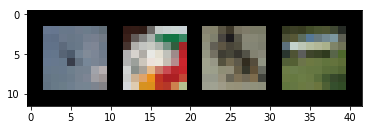

In [13]:
#See the images

def imshow(img):
    """ show an image """
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
# get some random training images
images, im_ta = train_data_iter.next()

# show images
print('Show some images of the training data')
imshow(torchvision.utils.make_grid(images))


Show the image targets


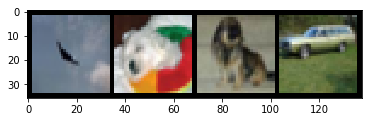

In [14]:
print('Show the image targets')
imshow(torchvision.utils.make_grid(im_ta))


In [15]:
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, Upsample
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax



channels = 3

num_filters_conv1 = 64
kernel_size_conv1 = 3 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
padding_conv1= int((kernel_size_conv1-1)/2)

num_filters_conv2 = 64
kernel_size_conv2 = 5 
stride_conv2 = 1
padding_conv2= int((kernel_size_conv2-1)/2)

num_filters_conv3 = 128
kernel_size_conv3 = 5
stride_conv3 = 1
padding_conv3= int((kernel_size_conv3-1)/2)

num_filters_conv4 = 64
kernel_size_conv4 = 5
stride_conv4 = 1
padding_conv4= int((kernel_size_conv4-1)/2)

num_filters_conv5 = 3
kernel_size_conv5 = 5
stride_conv5 = 1
padding_conv5= int((kernel_size_conv5-1)/2)



In [16]:
class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
                
        #Convolution layers
        self.conv_1 = Conv2d(in_channels=channels,out_channels=num_filters_conv1,
                            kernel_size=kernel_size_conv1,stride=stride_conv1, padding= padding_conv1)
        
        
        self.up = Upsample(scale_factor=2, mode='bicubic')

        
        self.conv_2 = Conv2d(in_channels=num_filters_conv1,out_channels=num_filters_conv2,
                            kernel_size=kernel_size_conv2,stride=stride_conv2, padding= padding_conv2)        
        
        self.conv_3 = Conv2d(in_channels=num_filters_conv2,out_channels=num_filters_conv3,
                            kernel_size=kernel_size_conv3,stride=stride_conv3, padding= padding_conv3)

                
        self.conv_4 = Conv2d(in_channels=num_filters_conv3,out_channels=num_filters_conv4,
                            kernel_size=kernel_size_conv4,stride=stride_conv4, padding= padding_conv4)
        
        
        self.conv_5 = Conv2d(in_channels=num_filters_conv4,out_channels=num_filters_conv5,
                            kernel_size=kernel_size_conv5,stride=stride_conv5, padding= padding_conv5)



    def forward(self, x):
        
        x = relu(self.conv_1(x))
        x = relu(self.up(x))
        x = relu(self.conv_2(x))
        x = relu(self.up(x))
        x = relu(self.conv_3(x))
        x = relu(self.conv_4(x))
        x = relu(self.conv_5(x))

        return x
    
    
net = Net()
net.cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up): Upsample(scale_factor=2.0, mode=bicubic)
  (conv_2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_4): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_5): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [17]:
myin=Variable(images).cuda()
myout=net(myin)
myout.cpu().data
myout.shape

C:\Users\Bruger\Anaconda3\lib\site-packages\torch\nn\functional.py:3121: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([4, 3, 32, 32])

In [18]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=10**(-3),momentum= 0.9)
"""
optimizer = optim.SGD([ {'params': net.conv_1.parameters()},
                        {'params': net.conv_2.parameters(), 'lr': 1e-4, 'momentum':0.9},
                        {'params': net.conv_3.parameters(), 'lr': 1e-5, 'momentum':0.9}
                        ], lr=1e-4, momentum=0.9)
"""

criterion = nn.MSELoss()

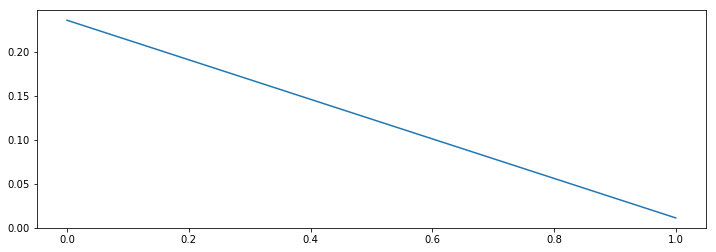

In [19]:
num_epoch = 2
log_every = len(trainloader)  #(batches)
losslist=[]
epochlist=[]

for epoch in range(num_epoch):  # loop over the dataset multiple times
    
    epochlist.append(epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, ta = data

        # wrap them in Variable
        inputs, ta = Variable(inputs), Variable(ta).cuda()
        inputs = inputs.float().cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        batch_loss = criterion(output, ta)
        batch_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += batch_loss.cpu().data
        
        if i % log_every == 0:    
            losslist.append(running_loss)
            
            fig = plt.figure(figsize=(12,4))
            plt.plot(epochlist, losslist)
            plt.show()
            clear_output(wait=True)

            running_loss = 0.0


In [20]:
#Check results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


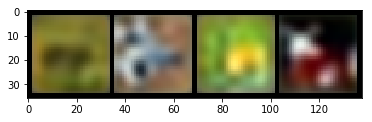

In [21]:
im_in, im_ta = test_data_iter.next()
im_in=Variable(im_in.float())
im_out=net(im_in.cuda())

toshow=im_out.cpu().data

imshow(torchvision.utils.make_grid(toshow))

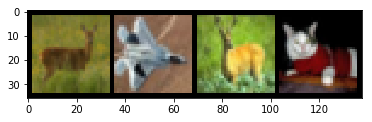

In [22]:
imshow(torchvision.utils.make_grid(im_ta))

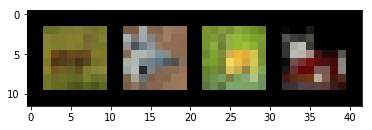

In [23]:
imshow(torchvision.utils.make_grid(im_in.cpu().data))

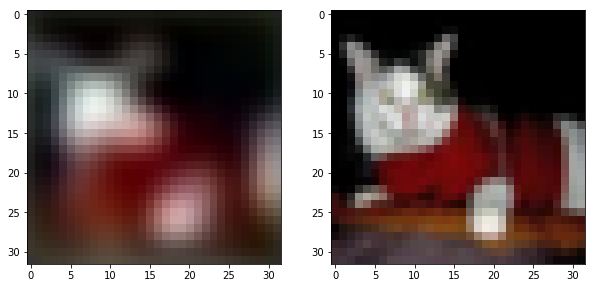

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.transpose(toshow[3,:,:,:], (1, 2, 0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(im_ta.cpu().data[3,:,:,:], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


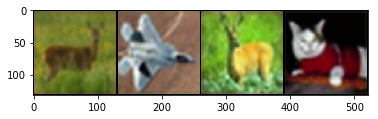

In [26]:
im_in=Variable(im_ta)
im_out=net(im_in.cuda())

toshow=im_out.cpu().data

imshow(torchvision.utils.make_grid(toshow))

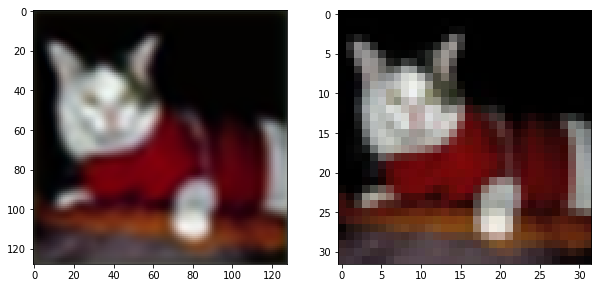

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.transpose(toshow[3,:,:,:], (1, 2, 0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(im_ta.cpu().data[3,:,:,:], (1, 2, 0)))

In [31]:
torch.save(net,'cnnnetwork')